# Analysis

## Contents

The notebook is laid out as follows:

* Loading the data
* Chart Data Exploration
* One Hit Wonders
* Last FM data
* Recommendations

I will also export it to PDF just in case it fails to render.

In [1]:
import pathlib
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.set_option("max_columns", 40)

## Load Data

The data is stored in a sqlite database, comprised of four tables (linked either with `lastfm_id` or `artist_name, song_name`):

* charts: The UK chart data, scraped from the website.
* lastfm: The lastfm data for the tracks.
* lastfm_tags: The song tag data.
* lastfm_artists: The artists from lastfm.

This is primarily as sometimes I think it is better to work in SQL for certain types of analysis 
(in particular, it's hard to beat the expressiveness of window functions).

In [2]:
dataset_path = pathlib.Path("../data/dataset.sqlite")
conn = sqlite3.connect(dataset_path)

In [3]:
def sql(query: str) -> pd.DataFrame:
    """Helper function for querying the database."""
    return pd.read_sql_query(query, conn)

## Sanity Checks

Below are some sanity checks for the data we're loading, to make sure it can be loaded and that it looks alright.

In [4]:
# Can we load the data?
charts = sql("SELECT * FROM charts ORDER BY week_ending DESC")
charts.head()

charts.to_excel("../data/charts_dump.xlsx", index=False)

In [5]:
# Check that the dates make sense.
query = """
SELECT MIN(year), MAX(year), COUNT(DISTINCT year), COUNT(DISTINCT chart_id), COUNT(*) FROM
(SELECT STRFTIME('%Y', week_ending) AS year, chart_id FROM charts) a
"""
sql(query)

,MIN(year),MAX(year),COUNT(DISTINCT year),COUNT(DISTINCT chart_id),COUNT(*)
0,1980,2010,31,1566,148987


In [6]:
# 1566 * 100 != 148987 - which I think is because the charts didn't always have 100 entries.
query = """
SELECT chart_id, COUNT(*) AS cnt
FROM charts
GROUP BY chart_id
"""
sql(query)

,chart_id,cnt
0,7501-19800105,75
1,7501-19800112,75
2,7501-19800119,75
3,7501-19800126,75
4,7501-19800202,75
...,...,...
1561,7501-20091205,100
1562,7501-20091212,100
1563,7501-20091219,100
1564,7501-20091226,100


## Chart Data Exploration

Below are charts and tables that I used to understand the dataset.

In [7]:
# Summary stats
sql(
    """
SELECT 
    COUNT(DISTINCT artist_name), 
    COUNT(DISTINCT chart_id), 
    COUNT(DISTINCT product_id), 
    COUNT(DISTINCT song_name), 
    COUNT(DISTINCT label_name)
FROM charts
"""
).T

,0
COUNT(DISTINCT artist_name),11832
COUNT(DISTINCT chart_id),1566
COUNT(DISTINCT product_id),32336
COUNT(DISTINCT song_name),25642
COUNT(DISTINCT label_name),2471


In [8]:
# Filtering out outliers with 100+ chart appearances
df = sql(
    """
    SELECT artist_name, COUNT(DISTINCT chart_id) AS chart_appearances, COUNT(DISTINCT product_id) AS unique_songs
    FROM charts 
    GROUP BY artist_name 
    HAVING chart_appearances < 100
"""
)

<AxesSubplot:>

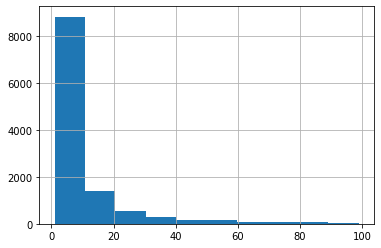

In [9]:
# What's the spread of artists by the number of appearances they've made in the charts?
df.chart_appearances.hist()

<AxesSubplot:>

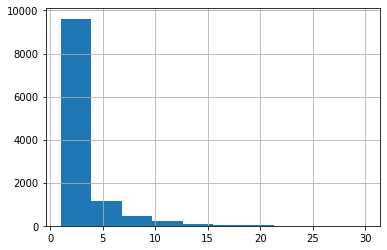

In [10]:
# What's the spread of artists by the number of appearances they've made in the charts?
df.unique_songs.hist()

In [11]:
# How well do songs do?
df = sql(
    """
SELECT artist_name, song_name, MIN(week_ending) AS first_week_ending, COUNT(DISTINCT chart_id) AS total_weeks
FROM charts
GROUP BY 1, 2
"""
)
df.sort_values(by="total_weeks", ascending=False).head(10)

,artist_name,song_name,first_week_ending,total_weeks
25054,SNOW PATROL,CHASING CARS,2006-07-29 00:00:00,137
19900,OASIS,WHATEVER,1994-12-31 00:00:00,110
26634,TAKE THAT,RULE THE WORLD,2007-10-27 00:00:00,92
19891,OASIS,SOME MIGHT SAY,1995-05-06 00:00:00,81
14799,KILLERS,MR BRIGHTSIDE,2004-06-05 00:00:00,81
19878,OASIS,CIGARETTES & ALCOHOL,1994-10-22 00:00:00,79
10062,FLO RIDA FT T-PAIN,LOW,2008-02-16 00:00:00,75
19423,NEW ORDER,BLUE MONDAY,1983-03-19 00:00:00,74
19902,OASIS,WONDERWALL,1995-11-11 00:00:00,74
1257,AMY WINEHOUSE,REHAB,2006-10-28 00:00:00,73


<AxesSubplot:>

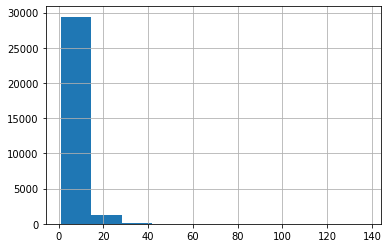

In [12]:
df.total_weeks.hist()

<AxesSubplot:>

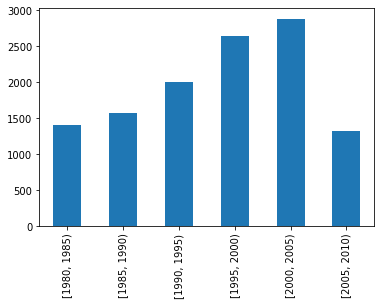

In [13]:
# How many new entrants are there over time?
df = sql(
    """
SELECT artist_name, MIN(week_ending) AS first_chart_week
FROM charts
GROUP BY 1
"""
)
new_artists = pd.to_datetime(df.first_chart_week).dt.year
# .sort_index().plot.bar(figsize=(12,6))
pd.cut(
    new_artists, bins=[1980, 1985, 1990, 1995, 2000, 2005, 2010], right=False
).value_counts().sort_index().plot.bar()

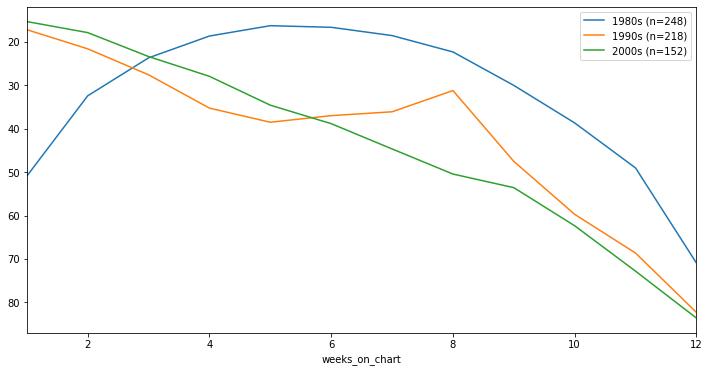

In [14]:
# Can we understand how songs perform on a track over time?
# The drop off % might be useful for estimating longer term performance
weeks_on_chart = sql(
    """
SELECT
    SUBSTR(STRFTIME('%Y', MIN(week_ending) OVER (PARTITION BY artist_name, song_name)), 0, 4) AS decade,
    product_id,
    artist_name, 
    song_name,
    1 + (julianday(week_ending) - julianday(MIN(week_ending) OVER (PARTITION BY artist_name, song_name)))/7 AS weeks_on_chart,
    position
FROM charts
ORDER BY weeks_on_chart DESC
"""
)
time_on_chart = weeks_on_chart.groupby("product_id").weeks_on_chart.max()
time_on_chart = time_on_chart[time_on_chart == 12]

weeks_on_chart = weeks_on_chart[weeks_on_chart.product_id.isin(time_on_chart.index)]
grouped = weeks_on_chart.groupby(["decade"]).apply(
    lambda g: g.groupby("weeks_on_chart").agg({"position": ["mean", "sem"]})
)
songs_by_decade = weeks_on_chart.groupby(["decade"]).product_id.nunique().to_dict()
fig, ax = plt.subplots(figsize=(8, 6))
for decade, group in grouped.reset_index().groupby("decade"):
    group.plot.line(
        x="weeks_on_chart",
        y=("position", "mean"),
        figsize=(12, 6),
        xlim=[1, 12],
        legend=True,
        ax=ax,
        label=f"{decade}0s (n={songs_by_decade[decade]})",
    )
plt.gca().invert_yaxis()

## One Hit Wonders

### Identifying One Hit Wonders

I have defined one hit wonders as when an artist has the majority of their top 40 success concentrated around one song (I've picked 2/3 of hit weeks on the chart).

I have also filtered out some terms for things like "FT"  in order to limit the number of collaborations in the charts.

In [15]:
query = """
SELECT * FROM (
  SELECT 
  artist_name, 
  song_name, 
  first_week_ending,
  max_chart_run, 
  peak_position, 
  CAST(max_chart_run AS float) / SUM(max_chart_run) OVER (PARTITION BY artist_name) share_of_weeks -- What % of weeks did this particular song occupy?
  FROM (
    SELECT
      artist_name,
      song_name,
      MIN(week_ending) AS first_week_ending,
      MIN(peak_position) AS peak_position,
      MAX(weeks_on_chart) AS max_chart_run
    FROM
    charts
    GROUP BY 1, 2
    HAVING peak_position <= 40
 )
)
WHERE 1=1 -- Helper statement
   AND share_of_weeks >= 0.67 -- must be at least above 50% to achieve "one hit"
   -- Filter out collaborations
   AND artist_name NOT LIKE '%FT%'
   AND artist_name NOT LIKE '%FEATURING%'
   AND artist_name NOT LIKE '%&%'
   AND artist_name NOT LIKE '%AND%'
   AND artist_name NOT LIKE '%VS%'
   AND artist_name NOT LIKE '%/%'
ORDER BY 3 DESC, 4 DESC
"""
one_hit_artists = sql(query)
one_hit_artists.to_excel("../data/output_one_hit_artists.xlsx", index=False)

In [16]:
# Helper view for later joins + the lastfm script.
view = f"""
CREATE VIEW v_one_hit_wonders AS
{query}
"""
# view = conn.execute(view)

In [17]:
one_hit_wonders = sql("SELECT * FROM v_one_hit_wonders")
one_hit_artists["first_week_ending"] = pd.to_datetime(
    one_hit_artists["first_week_ending"]
)

In [18]:
# Not often you get to look for bangers as part of your sense check
one_hit_artists.sort_values(by="max_chart_run", ascending=False).head(10)

,artist_name,song_name,first_week_ending,max_chart_run,peak_position,share_of_weeks
57,JASON MRAZ,I'M YOURS,2008-12-06,54,11,1.000000
158,FRAY,HOW TO SAVE A LIFE,2007-01-27,53,4,0.697368
281,BODYROCKERS,I LIKE THE WAY,2005-04-30,52,3,1.000000
170,GOO GOO DOLLS,IRIS/STAY WITH YOU,2006-10-21,51,26,0.927273
90,SAM SPARRO,BLACK & GOLD,2008-03-29,47,2,1.000000
266,DANIEL POWTER,BAD DAY,2005-08-06,45,2,1.000000
126,NEWTON FAULKNER,DREAM CATCH ME,2007-08-04,43,7,1.000000
975,TELETUBBIES,TELETUBBIES SAY EH-OH!,1997-12-13,41,1,1.000000
91,GABRIELLA CILMI,SWEET ABOUT ME,2008-03-15,41,6,0.759259
71,MADCON,BEGGIN',2008-08-23,40,5,1.000000


### Analysis

<AxesSubplot:xlabel='first_week_ending'>

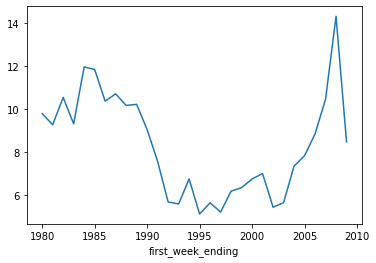

In [19]:
# Average runs on the chart rose dramatically from 2000-2010 - they might be better known.
one_hit_artists.groupby(
    one_hit_artists.first_week_ending.dt.year
).max_chart_run.mean().plot.line()

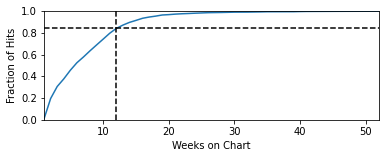

In [20]:
# Can we measure "sucess" by longevity in the charts?
pareto_artists_by_num_weeks = (
    one_hit_artists.groupby("max_chart_run").size().div(len(one_hit_artists)).cumsum()
)
ax = pareto_artists_by_num_weeks.plot.line(
    figsize=(6, 2),
    xlabel="Weeks on Chart",
    ylabel="Fraction of Hits",
    xlim=[1, 52],
    ylim=[0, 1],
)
percentile = pareto_artists_by_num_weeks[pareto_artists_by_num_weeks > 0.84].index[0]
plt.axvline(percentile, color="k", linestyle="--")
plt.axhline(0.84, color="k", linestyle="--")

<AxesSubplot:>

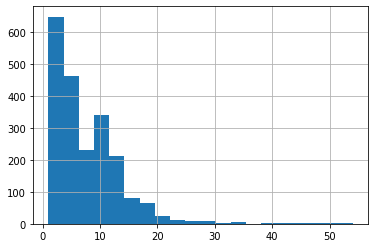

In [21]:
# Success? Number of runs on the chart - majority aren't that successful (<5 weeks on the chart, but some really linger on for up to a year on the chart)
one_hit_artists.max_chart_run.hist(bins=20)

<AxesSubplot:>

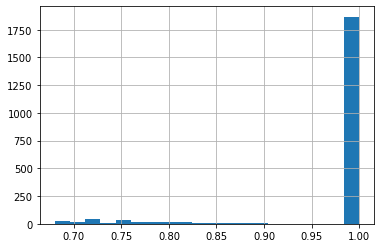

In [22]:
# Do one hit artists typically tend to have other tracks that do well? - No
one_hit_artists.share_of_weeks.hist(bins=20)

<AxesSubplot:>

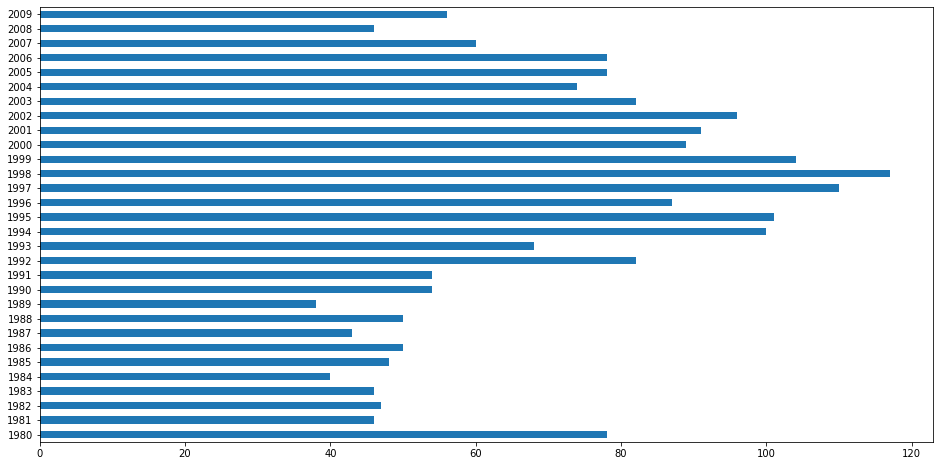

In [23]:
# Too detailed, but showcases how there's a lot of growth over the last 90s/00s.
one_hit_artists.first_week_ending.dt.year.value_counts().sort_index().plot.barh(
    figsize=(16, 8)
)

<AxesSubplot:xlabel='cohort', ylabel='Number of One Hit Wonders'>

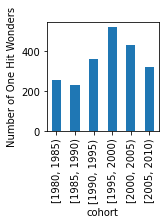

In [24]:
# One hit wonders start to grow up until 2000 where it begins to peak.
# Q: who were people listening to post recession?
one_hit_wonders_by_cohort = (
    pd.cut(
        one_hit_artists.first_week_ending.dt.year,
        bins=[1980, 1985, 1990, 1995, 2000, 2005, 2010],
        right=False,
    )
    .value_counts()
    .to_frame(name="one_hit_wonders")
)
one_hit_wonders_by_cohort.sort_index().plot.bar(
    legend=False,
    xlabel="cohort",
    ylabel="Number of One Hit Wonders",
    figsize=(2, 2), # Presentation friendly
)

<AxesSubplot:xlabel='cohort', ylabel='New Charting Acts'>

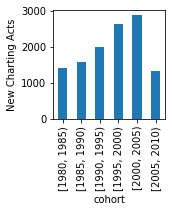

In [25]:
# Can we see if there are lots of artists vying for the charts?
new_artists_by_cohort = (
    pd.cut(new_artists, bins=[1980, 1985, 1990, 1995, 2000, 2005, 2010], right=False)
    .value_counts()
    .to_frame(name="new_artists")
)
new_artists_by_cohort.sort_index().plot.bar(
    legend=False, xlabel="cohort", ylabel="New Charting Acts", figsize=(2, 2)
)

In [26]:
# What tracks did  well in the recession?
one_hit_artists[
    one_hit_artists.first_week_ending.dt.year.isin([2007, 2008, 2009])
].sort_values(by="max_chart_run", ascending=False).head(20)

,artist_name,song_name,first_week_ending,max_chart_run,peak_position,share_of_weeks
57,JASON MRAZ,I'M YOURS,2008-12-06,54,11,1.000000
158,FRAY,HOW TO SAVE A LIFE,2007-01-27,53,4,0.697368
90,SAM SPARRO,BLACK & GOLD,2008-03-29,47,2,1.000000
126,NEWTON FAULKNER,DREAM CATCH ME,2007-08-04,43,7,1.000000
91,GABRIELLA CILMI,SWEET ABOUT ME,2008-03-15,41,6,0.759259
71,MADCON,BEGGIN',2008-08-23,40,5,1.000000
123,PLAIN WHITE T'S,HEY THERE DELILAH,2007-08-11,35,2,1.000000
113,RAY PARKER JR,GHOSTBUSTERS,2007-11-10,35,2,0.777778
67,MIA,PAPER PLANES,2008-09-13,34,19,1.000000
133,FERGIE,BIG GIRLS DON'T CRY,2007-06-30,33,2,0.702128


## Last.FM Data

### Data Exploration

In [27]:
# ~ 7 billion streams
sql("SELECT SUM(playcount) FROM lastfm")

,SUM(playcount)
0,723917022


In [28]:
# Slight tail off, possibly due to missed joins.
sql("SELECT COUNT(*) FROM lastfm")

,COUNT(*)
0,2016


In [29]:
# ~1 track has 3 labels
sql("SELECT COUNT(*) FROM lastfm_tags")

,COUNT(*)
0,7504


<AxesSubplot:ylabel='tag'>

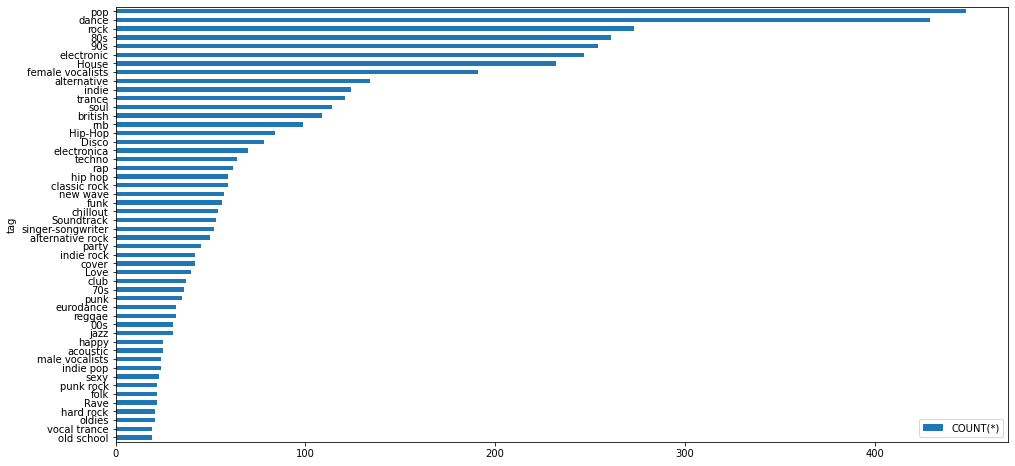

In [30]:
# What are some popular tags/genres?
sql(
    "SELECT tag, COUNT(*) FROM lastfm_tags GROUP BY 1 ORDER BY 2 DESC LIMIT 50"
).set_index("tag").sort_values(by="COUNT(*)", ascending=True).plot.barh(figsize=(16, 8))

<AxesSubplot:>

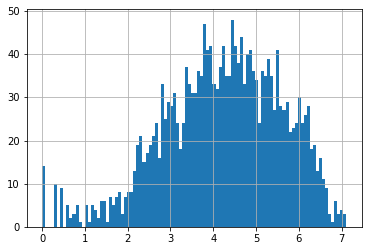

In [31]:
# The average hit has between 10-100k streams
sql("SELECT playcount FROM lastfm").playcount.map(np.log10).hist(bins=100)

<AxesSubplot:>

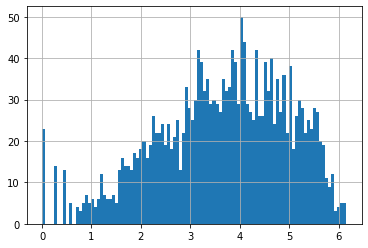

In [32]:
# Average hit has between 500-10,000 streams
sql("SELECT listeners FROM lastfm").listeners.map(np.log10).hist(bins=100)

<AxesSubplot:>

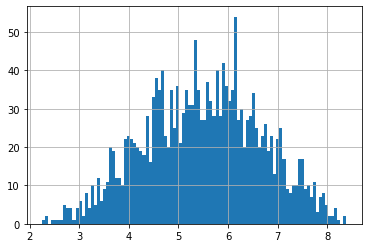

In [33]:
# Average artist has between 100k-1m streams
sql("SELECT playcount FROM lastfm_artists").playcount.map(np.log10).hist(bins=100)

<AxesSubplot:>

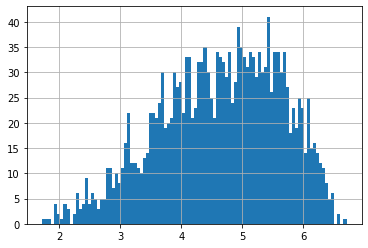

In [34]:
# Average artist has between 10k and 100k listeners
sql("SELECT listeners FROM lastfm_artists").listeners.map(np.log10).hist(bins=100)

array([[<AxesSubplot:title={'center':'pl_ratio'}>]], dtype=object)

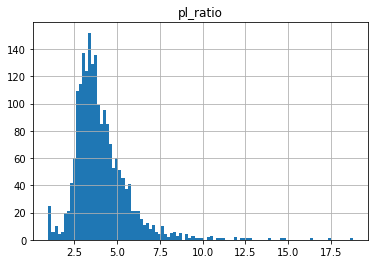

In [35]:
sql(
    "SELECT CAST(playcount AS FLOAT)/listeners AS pl_ratio FROM lastfm WHERE pl_ratio < 20"
).hist(bins=100)

In [36]:
pl_ratio_artists = sql(
    "SELECT CAST(playcount AS FLOAT)/listeners AS pl_ratio FROM lastfm_artists"
)
pl_ratio_artists.describe()

,pl_ratio
count,1814.000000
mean,9.152611
std,8.794331
min,2.346914
25%,4.513894
50%,6.227777
75%,10.192455
max,111.535817


### Analysing songs based on streaming habits

In [37]:
# Join together the tracks and add some features such as listener stickiness (song_pl_ratio)
query = """
SELECT
  DISTINCT c.*,
  l.*,
  la.playcount AS artist_playcount,
  la.listeners AS artist_listeners,
  CAST(l.playcount AS FLOAT)/l.listeners AS song_pl_ratio,
  CAST(la.playcount AS FLOAT)/la.listeners AS artist_pl_ratio,
  CAST(l.listeners AS FLOAT)/la.listeners AS song_artist_listener_ratio,
  CAST(l.playcount AS FLOAT)/la.playcount AS song_artist_playcount_ratio
FROM lastfm l
JOIN link_lastfm_chart lc ON lc.lastfm_id = l.lastfm_id
JOIN lastfm_artists la ON la.artist_mbid = l.artist_mbid
JOIN v_one_hit_wonders c ON c.artist_name = lc.artist_name AND c.song_name = lc.song_name
"""
ohw_stats = sql(query)
ohw_stats["first_week_ending"] = pd.to_datetime(ohw_stats.first_week_ending)

# sqlite annoyingly isn't as good an analytics database as I remember
# Add order of magnitude values for clearer reasoning
log10_cols = ["artist_playcount", "artist_listeners", "playcount", "listeners"]
for col in log10_cols:
    ohw_stats[f"log10_{col}"] = np.log10(ohw_stats[col])
ohw_stats["pct_split_playcount"] = (
    ohw_stats.sort_values(by="playcount", ascending=False)
    .playcount.cumsum()
    .div(ohw_stats.playcount.sum())
)
ohw_stats["playcount_rank"] = ohw_stats.playcount.rank(method="min", ascending=False)

# Generate a year cohort to make grouping easier
ohw_stats["year_cohort"] = pd.cut(
    ohw_stats.first_week_ending.dt.year,
    bins=[0, 1980, 1985, 1990, 1995, 2000, 2005, 2010],
    right=False,
)[ohw_stats.index]

In [38]:
# Can deterimine weighting from this
ohw_stats[["year_cohort"]].value_counts(normalize=True).sort_index()

year_cohort 
[0, 1980)       0.000000
[1980, 1985)    0.124728
[1985, 1990)    0.098039
[1990, 1995)    0.158497
[1995, 2000)    0.247821
[2000, 2005)    0.208061
[2005, 2010)    0.162854
dtype: float64

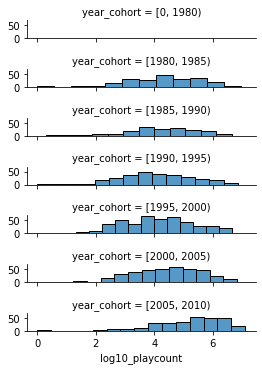

In [39]:
# Later charts (around advent of streaming) have more skew than earlier tracks
g = sns.FacetGrid(ohw_stats, row="year_cohort", aspect=5, height=0.75)
g.map(sns.histplot, "log10_playcount")

<AxesSubplot:xlabel='Cohort', ylabel='Average Streams (millions)'>

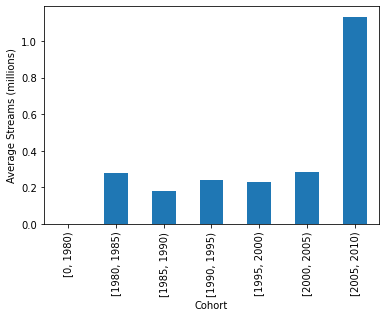

In [40]:
# Average is way higher
ohw_stats.groupby("year_cohort").playcount.mean().div(1_000_000).sort_index().plot.bar(
    ylabel="Average Streams (millions)", xlabel="Cohort"
)

### Analysing Tag Data

In [41]:
tags = sql(f"""SELECT * FROM lastfm_tags""")

In [42]:
# Build a genres table with some well known genres - nb, some tracks overlap
genres = [
    "indie",
    "folk",
    "pop",
    "dance",
    "rock",
    "alternative",
    "metal",
    "classic rock",
]
genres_table = tags[tags.tag.isin(genres)][["lastfm_id", "tag"]]
genres_table = (
    pd.get_dummies(genres_table, prefix="genre", columns=["tag"])
    .groupby("lastfm_id")
    .sum()
    .reset_index()
)  # Annoying bit of logic for uniqueness (one-to-many tags)
genres_table

,lastfm_id,genre_alternative,genre_classic rock,genre_dance,genre_folk,genre_indie,genre_metal,genre_pop,genre_rock
0,4,0,0,1,0,0,0,1,0
1,8,0,0,0,0,1,0,0,1
2,9,0,0,0,0,0,0,1,0
3,10,0,0,1,0,0,0,0,0
4,11,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1018,2008,1,0,0,0,0,0,0,1
1019,2009,0,0,1,0,0,0,0,0
1020,2010,0,0,0,0,1,0,1,0
1021,2011,0,0,0,0,0,0,1,0


In [43]:
# Build a time period table
time_periods = ["60s", "70s", "80s", "90s", "00s"]
time_table = tags[tags.tag.isin(time_periods)][["lastfm_id", "tag"]]
time_table = (
    pd.get_dummies(time_table, prefix="decade", columns=["tag"])
    .groupby("lastfm_id")
    .sum()
    .reset_index()
)
time_table

,lastfm_id,decade_00s,decade_60s,decade_70s,decade_80s,decade_90s
0,1,0,0,0,1,0
1,4,1,0,0,0,0
2,6,0,0,0,0,1
3,11,0,0,0,1,1
4,13,0,0,0,1,0
...,...,...,...,...,...,...
569,1990,0,0,0,0,1
570,2000,0,0,0,1,0
571,2001,0,0,0,1,0
572,2004,1,0,0,0,0


In [44]:
ohw_stats = ohw_stats.merge(time_table, on="lastfm_id", how="outer").merge(
    genres_table, on="lastfm_id", how="outer"
)
ohw_stats = ohw_stats[ohw_stats.artist_name.notnull()]

<AxesSubplot:>

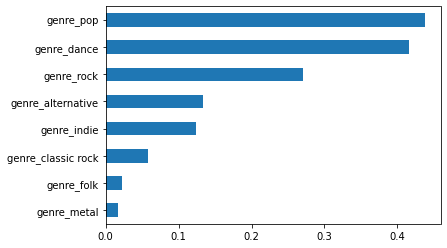

In [45]:
ohw_stats.filter(like="genre").mean().sort_values().plot.barh()

<AxesSubplot:>

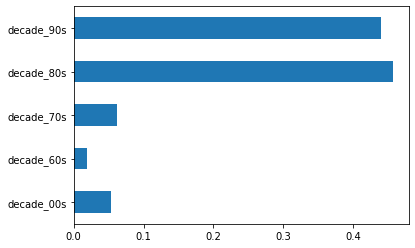

In [46]:
# Nostalgia factor? Why tag with "90s" etc otherwise?
ohw_stats.filter(like="decade").mean().plot.barh()

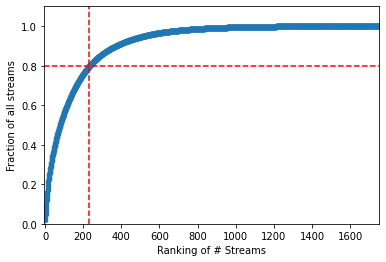

In [47]:
# 80% of listens come from about 233 of the songs
# 50% of listens come from 79 songs
ohw_stats.plot.scatter(
    x="playcount_rank",
    y="pct_split_playcount",
    xlim=[-5, 1750],
    ylim=[0, 1.1],
    xlabel="Ranking of # Streams",
    ylabel="Fraction of all streams",
)
ohw_stats[ohw_stats.pct_split_playcount <= 0.8].sort_values(
    by="pct_split_playcount", ascending=False
).iloc[0].playcount_rank

# Super hits
# plt.axvline(79, color="r", linestyle="--")
plt.axvline(233, color="r", linestyle="--")
plt.axhline(0.8, color="r", linestyle="--")
# plt.axhline(0.5, color="r", linestyle="--")

<AxesSubplot:xlabel='peak_position', ylabel='playcount'>

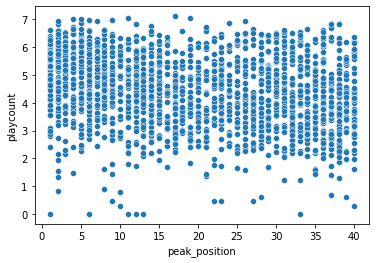

In [48]:
# Max peak position doesn't really have much of a bearing
sns.scatterplot(x=ohw_stats.peak_position, y=np.log10(ohw_stats.playcount))

<AxesSubplot:xlabel='max_chart_run', ylabel='playcount'>

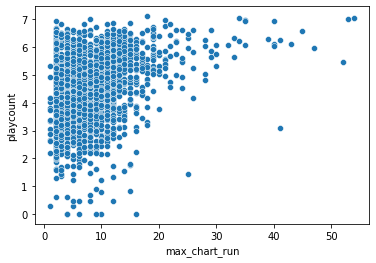

In [49]:
# Seems to have a switchpoint around the 20 week run mark (1/2 year), but it's so concentrated it's hard to tell if it's statistically significant
sns.scatterplot(x=ohw_stats.max_chart_run, y=np.log10(ohw_stats.playcount))

<AxesSubplot:>

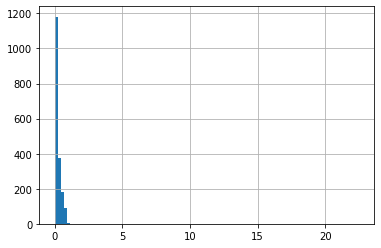

In [50]:
# A measure of how concentrated an artist's plays are around one song
ohw_stats.song_artist_playcount_ratio.hist(bins=100)

<AxesSubplot:>

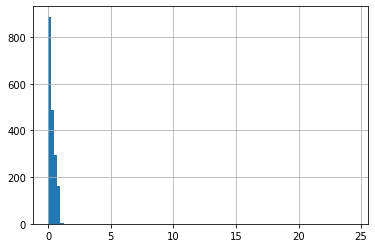

In [51]:
# measure of how concentrated an artist's listeners are around their one hit
ohw_stats.song_artist_listener_ratio.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

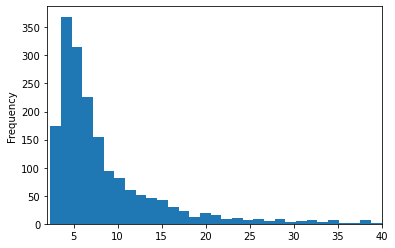

In [52]:
# Some artists have very sticky / concentrated fan bases
ohw_stats.artist_pl_ratio.plot.hist(bins=90, xlim=[2, 40])

<AxesSubplot:>

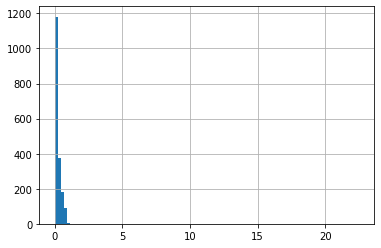

In [53]:
# Appears like most artists plays are not heavily concentrated in their one hits - possibly a proxy for popularity?
ohw_stats.song_artist_playcount_ratio.hist(bins=100)

<AxesSubplot:>

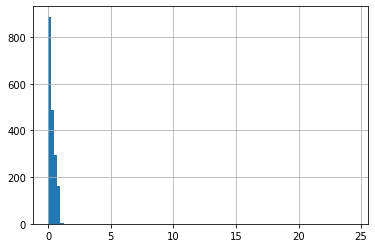

In [54]:
# Looks like artists have more concentrated listeners around their major hits, maybe it's a measure of their catalogue's longer term popularity?
ohw_stats.song_artist_listener_ratio.hist(bins=100)

In [55]:
# Top tracks with high listeners are not really big artists
ohw_stats.sort_values(by="song_artist_playcount_ratio", ascending=False).head(10)

,artist_name,song_name,first_week_ending,max_chart_run,peak_position,share_of_weeks,lastfm_id,listeners,playcount,duration,mbid,artist_mbid,artist_playcount,artist_listeners,song_pl_ratio,artist_pl_ratio,song_artist_listener_ratio,song_artist_playcount_ratio,log10_artist_playcount,log10_artist_listeners,log10_playcount,log10_listeners,pct_split_playcount,playcount_rank,year_cohort,decade_00s,decade_60s,decade_70s,decade_80s,decade_90s,genre_alternative,genre_classic rock,genre_dance,genre_folk,genre_indie,genre_metal,genre_pop,genre_rock
1228,PETER CETERA,GLORY OF LOVE,1986-08-02,13.0,3.0,1.0,902,172318.0,699315.0,260000.0,09970bad-8cfe-4c74-a940-be7fd13fa5f7,cdcd53c9-f37c-48cc-b7e3-dfe34be22e92,31095.0,7084.0,4.058282,4.389469,24.324958,22.489629,4.492691,3.850279,5.844673,5.236331,0.817518,251.0,"[1985, 1990)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1274,PROPELLERHEADS,SPYBREAK!,1997-05-17,2.0,40.0,1.0,828,111518.0,377752.0,420000.0,ed0c9373-6ffa-4c60-83d4-9b3b673c10c7,cbaafb20-eb74-421a-85f1-2bb6341aad23,40143.0,11735.0,3.387363,3.420793,9.503025,9.410159,4.603610,4.069483,5.577207,5.047345,0.889168,350.0,"[1995, 2000)",NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
575,FOUR BUCKETEERS,THE BUCKET OF WATER SONG,1980-05-03,6.0,26.0,1.0,487,121.0,307.0,172000.0,None,5270d69b-bf85-4399-949e-3a971bf2e981,311.0,122.0,2.537190,2.549180,0.991803,0.987138,2.492760,2.086360,2.487138,2.082785,0.999977,1714.0,"[1980, 1985)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
833,KATE WINSLET,WHAT IF,2001-12-08,17.0,6.0,1.0,708,57044.0,287372.0,244000.0,af45aab5-1c23-4ef6-acb1-e1ebe73c3e03,ceb05831-03e8-4605-904d-894ee0492d00,307011.0,60293.0,5.037725,5.091984,0.946113,0.936032,5.487154,4.780267,5.458444,4.756210,0.916507,410.0,"[2000, 2005)",NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
559,FERRY AID,LET IT BE,1987-04-04,7.0,1.0,1.0,242,4743.0,13265.0,NaN,1138308e-d67d-4b19-b4e0-c85382c2ec29,590233d0-5ab2-4a67-8f43-a647c2100bdc,14261.0,4924.0,2.796753,2.896223,0.963241,0.930159,4.154150,3.692318,4.122707,3.676053,0.996425,1088.0,"[1985, 1990)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1721,TWISTED X,BORN IN ENGLAND,2004-06-19,3.0,9.0,1.0,693,573.0,1857.0,180000.0,52acd439-d243-4ff7-9f25-e240a51d6bbf,a330ac7f-4722-465f-938f-7c7a703219f0,2027.0,625.0,3.240838,3.243200,0.916800,0.916132,3.306854,2.795880,3.268812,2.758155,0.999684,1480.0,"[2000, 2005)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,BOY MEETS GIRL,WAITING FOR A STAR TO FALL,1988-11-26,14.0,9.0,1.0,877,110650.0,542361.0,321000.0,80214d59-9f71-4cee-b3fb-f677720eaa7b,1752572e-2179-4507-9214-b29a6f2d7888,592946.0,114253.0,4.901591,5.189763,0.968465,0.914689,5.773015,5.057868,5.734288,5.043951,0.851879,291.0,"[1985, 1990)",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1199,PARTNERS IN KRYME,TURTLE POWER,1990-07-21,10.0,1.0,1.0,1498,7622.0,28986.0,230000.0,00db40ea-7874-4a4f-8c2f-96cbc1988115,7e3b1e89-9dc4-44ff-bb47-21be91a3dd72,32067.0,8221.0,3.802939,3.900620,0.927138,0.903920,4.506058,3.914925,4.462188,3.882069,0.991306,907.0,"[1990, 1995)",0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,4-4-2,COME ON ENGLAND,2004-06-19,5.0,2.0,1.0,5,1223.0,4241.0,223000.0,553af8f8-75f6-444f-a658-997682893a4d,e4a47762-3b26-4263-a756-6fd2c3e425a8,4740.0,1341.0,3.467702,3.534676,0.912006,0.894726,3.675778,3.127429,3.627468,3.087426,0.999085,1333.0,"[2000, 2005)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
265,CAST FROM CASUALTY,EVERLASTING LOVE,1998-03-14,9.0,5.0,1.0,65,55.0,187.0,171000.0,None,33542e9c-48af-4b98-8fbd-bda7383881c3,210.0,59.0,3.400000,3.559322,0.932203,0.890476,2.322219,1.770852,2.271842,1.740363,0.999991,1756.0,"[1995, 2000)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 0, 'Listener Stickiness (Song)')

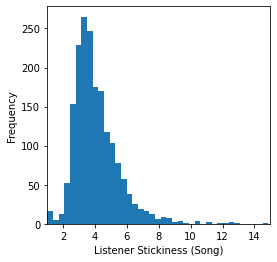

In [56]:
# For artists, this is effectively a measure of how concentrated their fan base is in tandem with the play concentration
a = ohw_stats.song_pl_ratio.plot.hist(
    bins=90, xlim=[1, 15], xlabel="Listener Stickiness (Song)", figsize=(4, 4)
)
a.set_xlabel("Listener Stickiness (Song)")

Text(0.5, 0, 'Fraction of song plays vs total')

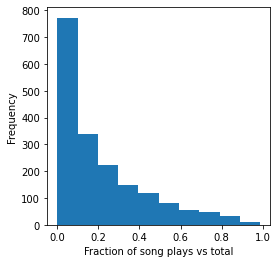

In [57]:
a = ohw_stats[
    ohw_stats.song_artist_playcount_ratio <= 1
].song_artist_playcount_ratio.plot.hist(
    xlabel="Fraction of song plays vs total", figsize=(4, 4)
)
a.set_xlabel("Fraction of song plays vs total")

9.184217837778288


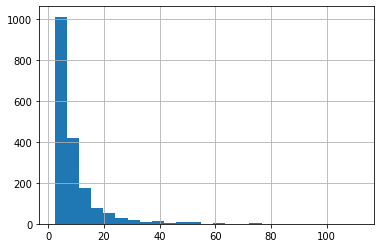

In [58]:
# For artists, this is effectively a measure of how concentrated their fan base is
ohw_stats.artist_pl_ratio.hist(bins=25)
print(ohw_stats.artist_pl_ratio.mean())

In [59]:
## Some feature engineering to get a feeling for how the tracks fare by 
## May not include in final report, one big question that it raises is "when were the majority of streams?" otherwise could hugely bias the dataset
## towards the more recent tracks.

import datetime

def years_since_spotify(row: pd.Timestamp) -> float:
    """Computes how many listens per year a track has had since the advent of spotify."""
    end_date = pd.Timestamp(2021, 8, 6)
    reference_date = pd.Timestamp(2006, 4, 23)

    # If the song came out after spotify, then count that  directly.
    if row > reference_date:
        reference_date = row
    return (end_date - reference_date).days / 365.25


ohw_stats["years_since_spotify"] = ohw_stats.first_week_ending.map(years_since_spotify)
ohw_stats["annual_song_streams_since_spotify"] = (
    ohw_stats.playcount / ohw_stats.years_since_spotify
)
ohw_stats["annual_artist_streams_since_spotify"] = (
    ohw_stats.artist_playcount / ohw_stats.years_since_spotify
)

# https://www.indiemusicacademy.com/blog/music-royalties-explained
ohw_stats["gbp_annual_song_royalty_est"] = (
    ohw_stats.annual_song_streams_since_spotify * 0.066
)

In [60]:
# Come back if time - potentially too noisy with poor streaming data
# https://www.statista.com/statistics/885750/average-risk-free-rate-united-kingdom/
risk_free_rate = 0.013
def npv(years: int, risk_free_rate: float, coupon: int) -> float:
    result = []
    for year in range(years):
        result.append(coupon / (1 + risk_free_rate) ** year)
    return np.sum(result)

# Below - bit dubious w/o trend data
# ohw_stats["gbp_annual_song_royalty_npv_5yr"] = ohw_stats.gbp_annual_song_royalty_est.map(lambda r: npv(5, risk_free_rate, r))
# ohw_stats["gbp_annual_song_royalty_npv_10yr"] = ohw_stats.gbp_annual_song_royalty_est.map(lambda r: npv(10, risk_free_rate, r))
# ohw_stats["gbp_annual_song_royalty_5yr_price_at_irr"] = ohw_stats.gbp_annual_song_royalty_est.map(lambda r: npv(5, 0.1, r))

<AxesSubplot:ylabel='Frequency'>

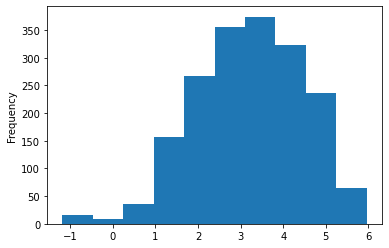

In [61]:
ohw_stats.annual_song_streams_since_spotify.map(np.log10).plot.hist()

<AxesSubplot:ylabel='Frequency'>

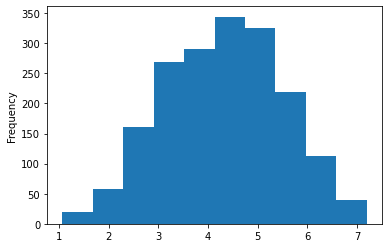

In [62]:
ohw_stats.annual_artist_streams_since_spotify.map(np.log10).plot.hist()

### Clustering Analysis

I use AffinityPropagation with a small feature set in order to group together songs with similar properties.
This is a proof of concept to highlight why data science can be useful for performing fast target scanning / comp. analysis.

In [63]:
# Some extra stuff - quick and dirty clustering to see if we can segment the ohw market
from sklearn.cluster import AffinityPropagation

model = AffinityPropagation(damping=0.9)
data = ohw_stats[
    [
        "song_artist_listener_ratio",
        "song_pl_ratio",
        "artist_pl_ratio",
        "peak_position",
        "share_of_weeks",
    ]
]
model.fit(data)
ohw_stats["cluster"] = model.predict(data)

/home/niall/Documents/Projects/[redacted]/assignment/venv/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


<AxesSubplot:>

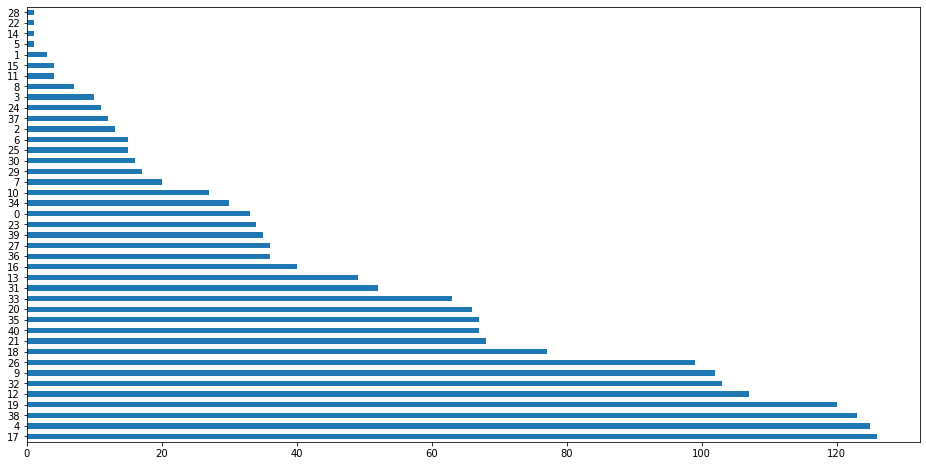

In [64]:
# Large skew - cluster 17 seems like a "catch all"
ohw_stats.cluster.value_counts().plot.barh(figsize=(16, 8))

### Searching for correlations

<AxesSubplot:xlabel='first_week_ending', ylabel='log10_playcount'>

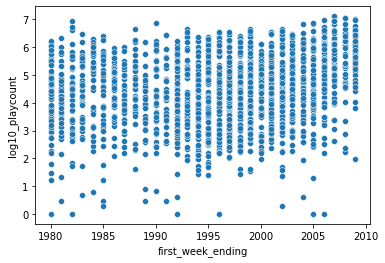

In [65]:
# Older songs don't appear to offer much of a leg up on newer songs for total streams
sns.scatterplot(x=ohw_stats.first_week_ending.dt.year, y=ohw_stats.log10_playcount)

<AxesSubplot:xlabel='first_week_ending', ylabel='log10_artist_playcount'>

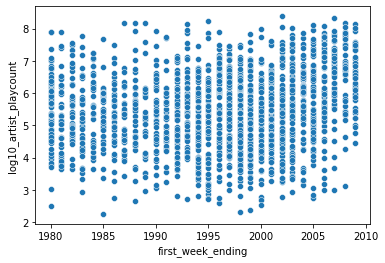

In [66]:
# Older songs don't appear to offer much of a leg up on newer songs for total streams
sns.scatterplot(
    x=ohw_stats.first_week_ending.dt.year, y=ohw_stats.log10_artist_playcount
)

<AxesSubplot:xlabel='first_week_ending', ylabel='log10_listeners'>

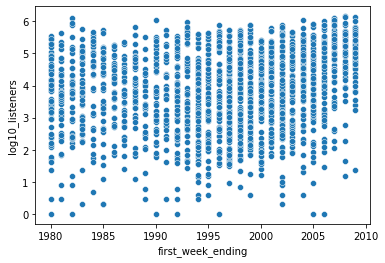

In [67]:
# Nor for listeners except on average
sns.scatterplot(x=ohw_stats.first_week_ending.dt.year, y=ohw_stats.log10_listeners)

<AxesSubplot:xlabel='first_week_ending', ylabel='log10_artist_listeners'>

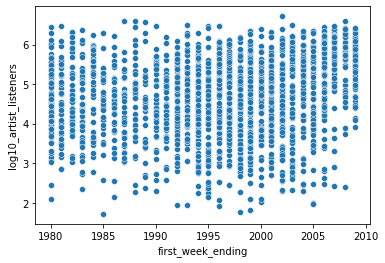

In [68]:
# Nor for listeners, mean number of listeners is higher
sns.scatterplot(
    x=ohw_stats.first_week_ending.dt.year, y=ohw_stats.log10_artist_listeners
)

<AxesSubplot:xlabel='log10_artist_playcount', ylabel='log10_playcount'>

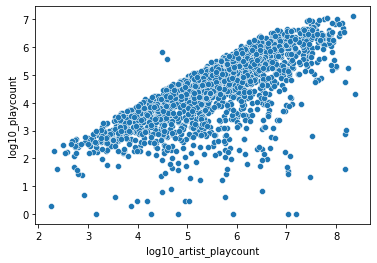

In [69]:
# The most listens the hit has, the better a predictor of the artist's overall listens?
sns.scatterplot(x=ohw_stats.log10_artist_playcount, y=ohw_stats.log10_playcount)

<AxesSubplot:xlabel='log10_artist_listeners', ylabel='log10_listeners'>

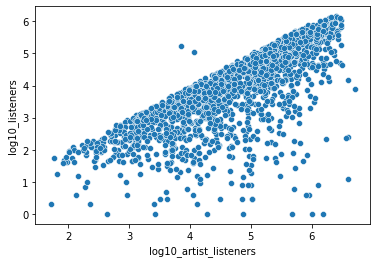

In [70]:
# Popular songs help artists with their overall portfolio
sns.scatterplot(x=ohw_stats.log10_artist_listeners, y=ohw_stats.log10_listeners)

<AxesSubplot:xlabel='log10_artist_listeners', ylabel='song_pl_ratio'>

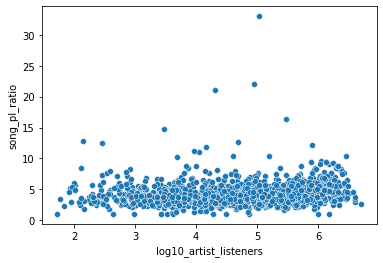

In [71]:
sns.scatterplot(x=ohw_stats.log10_artist_listeners, y=ohw_stats.song_pl_ratio)

## Recommendations

In order to build a stable portfolio that will generate revenue, I focus on the following criteria:

* Top half of listens (do people want to listen to the songs?)
* Avoiding potentially very pricy top tier songs
* Songs which performed well in the charts (3+ months)
* Artists who aren't too niche (as measured by playcount)

Plus some smaller data filtering steps (to get rid of some datapoints that I didn't think made sense, e.g. Jimi Hendrix as a one hit wonder).

In [72]:
mask = ohw_stats.pct_split_playcount <= 0.5  # pick popular songs
mask &= (
    ohw_stats.pct_split_playcount > 0.1
)  # but not so popular that they'll be overpriced
mask &= (
    ohw_stats.duration < 4.5 * 60 * 1000
)  # pick shorter songs (just to filter out the nicher classic rock stuff)
mask &= (
    ohw_stats.max_chart_run >= 12
)  # pick songs that had more than 3 months of airtime on the charts
mask &= ohw_stats.song_artist_playcount_ratio <= 0.5
mask &= ohw_stats.decade_60s != 1
candidates = ohw_stats[mask]
candidates.sort_values(
    by=["year_cohort", "song_pl_ratio"], ascending=False
).sort_values(by="song_pl_ratio", ascending=False)

candidates.to_excel("../data/output_shortlist_review.xlsx", index=False)

In [73]:
## I reviewed by eye to identify the songs fit for portfolio.

selection_lds = [
    811,  # Best PL for 80s,
    1456,  # Best PL for 90s,
    252,  # Best PL for early 00s,
    1755,  # Third best PL for early 00s - different genre to best so I think that balances out better
    1605,  # Best PL for late 00s
]


def format_output_table(row: pd.Series) -> pd.Series:
    return pd.Series(
        [
            row.lastfm_id,
            row.artist_name,
            row.song_name,
            tags[tags.lastfm_id == row.lastfm_id].tag.tolist(),
            row.first_week_ending.year,
            row.playcount,
            row.song_pl_ratio,
            row.song_artist_playcount_ratio,
            row.cluster,
        ],
        index=[
            "lastfm_id",
            "artist",
            "song",
            "tags",
            "year",
            "total_plays",
            "listener_stickiness",
            "listening_concentration",
            "cluster",
        ],
    )


final_candidates = (
    candidates.loc[selection_lds]
    .apply(format_output_table, axis=1)
    .sort_values(by="listener_stickiness", ascending=False)
)
final_candidates

,lastfm_id,artist,song,tags,year,total_plays,listener_stickiness,listening_concentration,cluster
1605,1262,TEMPER TRAP,SWEET DISPOSITION,"[indie, indie rock, 500 Days of Summer, austra...",2009,9455762.0,9.492184,0.333081,30
811,1429,JOURNEY,DON'T STOP BELIEVIN',"[classic rock, 80s, rock, journey, scrubs]",1982,8982453.0,6.970458,0.279932,23
252,723,CAESARS,JERK IT OUT,"[indie, rock, alternative, indie rock, swedish]",2003,3002434.0,6.476597,0.390669,36
1456,355,SIXPENCE NONE THE RICHER,KISS ME,"[pop, 90s, female vocalists, Love, rock]",1999,4677837.0,5.934677,0.460359,18
1755,1997,VANESSA CARLTON,A THOUSAND MILES,"[pop, female vocalists, piano, vanessa carlton...",2002,3722367.0,5.552275,0.306132,36


### Using the cluster model to construct a similar portfolio automatically

In [74]:
# Demo of fast lookup based on clustering
mask = ohw_stats.cluster.isin(
    final_candidates.cluster
)  # Same clusters - some songs may be in a "unicluster", which is obviously a drawback for the proof-of-concept
mask &= ~ohw_stats.lastfm_id.isin(
    final_candidates.lastfm_id
)  # Don't pick the songs we know
mask &= ohw_stats.pct_split_playcount <= 0.5  # still focus on popular songs
mask &= ohw_stats.decade_60s != 1
ohw_stats[mask].sort_values(by="song_pl_ratio", ascending=False).groupby(
    "year_cohort"
).first().apply(format_output_table, axis=1).dropna().sort_values(
    by="listener_stickiness"
)

,lastfm_id,artist,song,tags,year,total_plays,listener_stickiness,listening_concentration,cluster
year_cohort,,,,,,,,,
"[1995, 2000)",1457.0,NEW RADICALS,YOU GET WHAT YOU GIVE,"[90s, rock, alternative, pop, alternative rock]",1999.0,3231926.0,5.478704,0.600575,18.0
"[2000, 2005)",404.0,JUNIOR SENIOR,MOVE YOUR FEET,"[dance, pop, electronic, fun, happy]",2003.0,2342399.0,5.510801,0.462756,18.0
"[1980, 1985)",1676.0,DEXY'S MIDNIGHT RUNNERS WITH THE EMERALD EXPRESS,COME ON EILEEN,"[80s, pop, new wave, british, rock]",1982.0,4271605.0,5.734545,0.662270,18.0
"[1985, 1990)",1201.0,TRACY CHAPMAN,FAST CAR,"[folk, acoustic, female vocalists, 80s, singer...",1988.0,4496842.0,6.739002,0.212117,23.0
"[2005, 2010)",53.0,JOSE GONZALEZ,HEARTBEATS,"[acoustic, chillout, indie, Mellow, singer-son...",2006.0,9539488.0,9.309897,0.208667,30.0


In [75]:
# Save the data for later
ohw_stats.to_excel("../data/output_one_hit_wonders_with_statistics.xlsx", index=False)
sql("SELECT * FROM lastfm").to_excel("../data/output_lastfm.xlsx", index=False)

### Some more tag analysis

In [76]:
# Are some genres more sticky than others?
pop_rock = ohw_stats.merge(
    sql("SELECT * FROM lastfm_tags WHERE tag in ('rock', 'dance', 'pop')"),
    on="lastfm_id",
)

<AxesSubplot:ylabel='first_week_ending'>

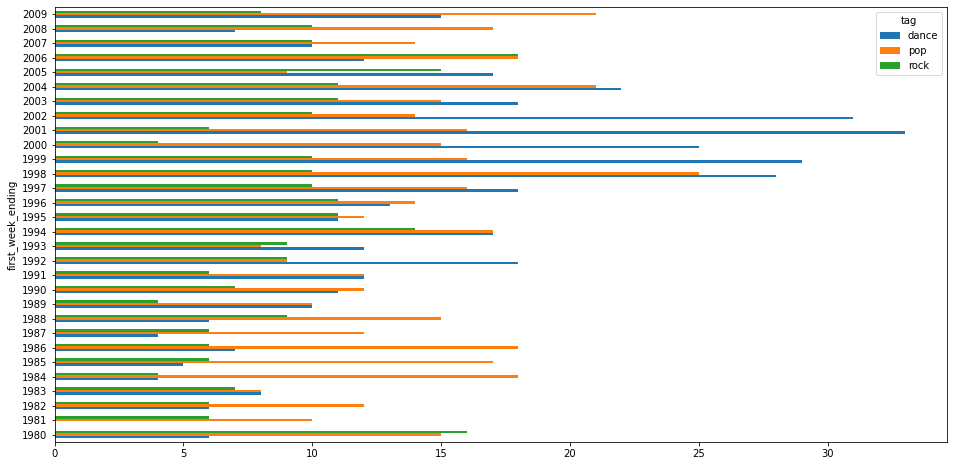

In [77]:
pop_rock.groupby(
    ["tag", pop_rock.first_week_ending.dt.year]
).size().reset_index().pivot(index="first_week_ending", columns="tag", values=0).fillna(
    0
).plot.barh(
    figsize=(16, 8)
)

Text(0.5, 0, 'Listener Stickiness')

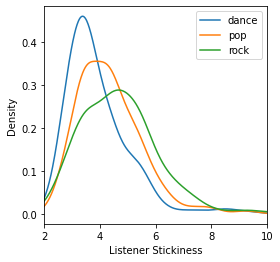

In [78]:
fig, ax = plt.subplots()
pop_rock.groupby("tag").song_pl_ratio.plot.kde(
    legend=True, xlim=[2, 10], figsize=(4, 4)
)
ax.set_xlabel("Listener Stickiness")

tag
dance    AxesSubplot(0.125,0.125;0.775x0.755)
pop      AxesSubplot(0.125,0.125;0.775x0.755)
rock     AxesSubplot(0.125,0.125;0.775x0.755)
Name: artist_pl_ratio, dtype: object

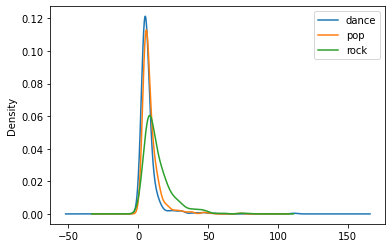

In [79]:
pop_rock.groupby("tag").artist_pl_ratio.plot.kde(legend=True)